In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

warnings.filterwarnings('ignore')

#encoding = utf-8

In [2]:
from sklearn.preprocessing import StandardScaler
data = pd.read_csv('C:/Users/ywb/Desktop/creditcard.csv')
scale = StandardScaler()
scaled_amount = scale.fit_transform(data.Amount.values.reshape(-1,1))
data = data.drop(['Time','Amount'],axis=1)
data['normamount'] = scaled_amount.reshape((-1,))

0    284315
1       492
Name: Class, dtype: int64


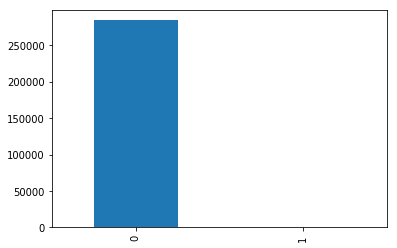

In [3]:
print(data.Class.value_counts())
data.Class.value_counts().plot(kind= 'bar')

# 样本不均衡问题的解决办法
### 1 下采样
### 2 过采样（SMOTE数据生成）

In [4]:
data.head(2)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,normamount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475


# 1 下采样法

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
# from sklearn.cross_validation import train_test_split
X = data.iloc[:,data.columns != 'Class']
Y = data.iloc[:,data.columns == 'Class']

#整体的划分
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.3,shuffle = True)
print(y_train.shape)
#下采样
neg_num = np.sum(data.Class != 0)
under_sample_positive = data[data.Class==0].sample(n=neg_num,replace=False)

under_sample_data = under_sample_positive.append(data[data.Class==1])

#生成下采样数据
under_sample_data = shuffle(under_sample_data)

under_x_train,under_x_test,under_y_train,under_y_test = train_test_split(under_sample_data.iloc[:,under_sample_data.columns!='Class'],
                                                                        under_sample_data.iloc[:,under_sample_data.columns =='Class'],
                                                                        test_size = 0.2,random_state = 11)

(199364, 1)


In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.cross_validation import KFold
from sklearn.metrics import recall_score,confusion_matrix,roc_curve,auc,precision_score,precision_recall_curve

In [32]:
def para_select():
    fold = KFold(len(under_x_train),n_folds=5,shuffle=True,random_state=11)
    c_para_set = [0.06,0.065]
    for c_pa in c_para_set:
        print('c值为  ：',c_pa)
        print('---------------------------------------------------------\n')
        recall_all =[]
        for i,slices in enumerate(fold):
            Lr = LogisticRegression(C=c_pa,penalty='l1')
            Lr.fit(X=under_x_train.iloc[slices[0],:], y=under_y_train.iloc[slices[0],:])
            under_y_pred = Lr.predict(under_x_train.iloc[slices[1],:])
            this_score = recall_score(under_y_pred,under_y_train.iloc[slices[1],:])
            recall_all.append(this_score)
            print('当前迭代轮数：{}   当前迭代recall：{}'.format(i,this_score))
        print('\nc值为{}时，平均recall值为{}'.format(c_pa,np.mean(recall_all)))
        print('---------------------------------------------------------\n')

    print('最好的L1惩罚项系数为c={}'.format(0.06))
    return

fold = KFold(len(under_x_train),n_folds=5,shuffle=True,random_state=11)
c_para_set = [0.06,0.065]
for c_pa in c_para_set:
    print('c值为  ：',c_pa)
    print('---------------------------------------------------------\n')
    recall_all =[]
    for i,slices in enumerate(fold):
        Lr = LogisticRegression(C=c_pa,penalty='l1')
        Lr.fit(X=under_x_train.iloc[slices[0],:], y=under_y_train.iloc[slices[0],:])
        under_y_pred = Lr.predict(under_x_train.iloc[slices[1],:])
        this_score = recall_score(under_y_pred,under_y_train.iloc[slices[1],:])
        recall_all.append(this_score)
        print('当前迭代轮数：{}   当前迭代recall：{}'.format(i,this_score))
    print('\nc值为{}时，平均recall值为{}'.format(c_pa,np.mean(recall_all)))
    print('---------------------------------------------------------\n')

c值为  ： 0.06
---------------------------------------------------------

当前迭代轮数：0   当前迭代recall：0.9850746268656716
当前迭代轮数：1   当前迭代recall：0.9701492537313433
当前迭代轮数：2   当前迭代recall：0.9696969696969697
当前迭代轮数：3   当前迭代recall：1.0
当前迭代轮数：4   当前迭代recall：0.9565217391304348

c值为0.06时，平均recall值为0.9762885178848839
---------------------------------------------------------

c值为  ： 0.065
---------------------------------------------------------

当前迭代轮数：0   当前迭代recall：0.9850746268656716
当前迭代轮数：1   当前迭代recall：0.9701492537313433
当前迭代轮数：2   当前迭代recall：0.9696969696969697
当前迭代轮数：3   当前迭代recall：1.0
当前迭代轮数：4   当前迭代recall：0.9565217391304348

c值为0.065时，平均recall值为0.9762885178848839
---------------------------------------------------------



0.97369280680992



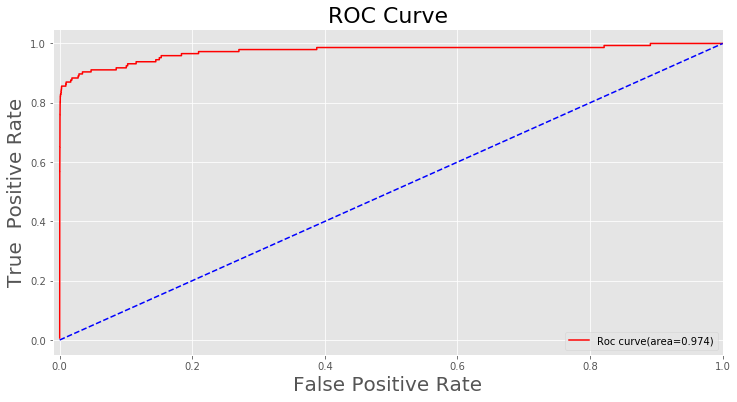

In [33]:
from sklearn import svm
model = LogisticRegression(C=0.06,penalty='l1')
# model = svm.SVC(probability=True)
model.fit(X=under_x_train.iloc[slices[0],:], y=under_y_train.iloc[slices[0],:])

#对整体数据分割得到的测试集进行测试
all_predprob = model.predict_log_proba(x_test.values)
all_pred = model.predict(x_test.values)
# print(metrics.accuracy_score(all_pred,y_test))
my_fpr,my_tpr,threshold = roc_curve(y_test,all_predprob[:,1],pos_label=1)

print(auc(my_fpr,my_tpr))
plt.figure(figsize=(12,6))
plt.style.use('ggplot')
plt.plot(my_fpr,my_tpr,'r-',label ='Roc curve(area=%0.3f)'%auc(my_fpr,my_tpr)) 
plt.legend(loc='best')
plt.xlabel('False Positive Rate',fontsize= 20)
plt.ylabel('True  Positive Rate',fontsize= 20)
plt.title('ROC Curve',fontsize = 22)

plt.plot([0,1],[0,1],'b--')
plt.xlim((-0.01,1))

plt.plot()
print()

In [34]:

cmt = confusion_matrix(y_test, all_pred,labels=[0,1])
cmt

array([[83803,  1494],
       [   18,   128]], dtype=int64)

Confusion matrix, without normalization
[[83803  1494]
 [   18   128]]
0.8767123287671232
0.07891491985203453


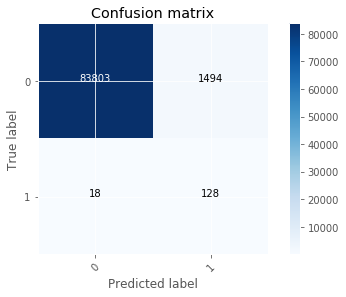

In [35]:

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    import itertools
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
plot_confusion_matrix(cmt,[0,1])
print(recall_score(y_test, all_pred))
print(precision_score(y_test, all_pred))

Text(0,0.5,'Recall')

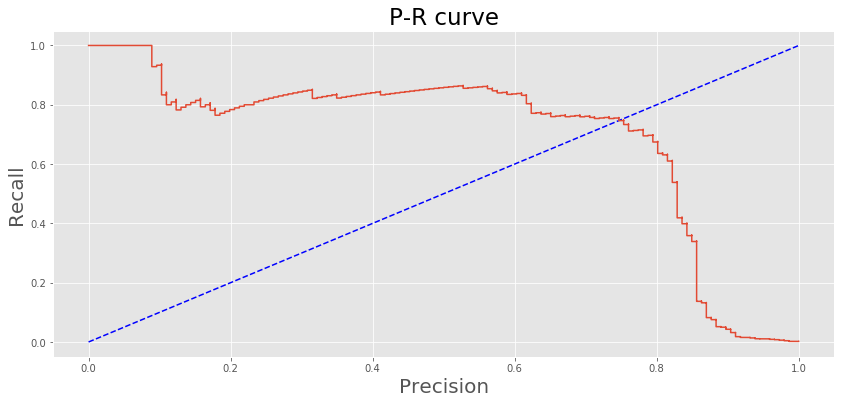

In [36]:
precision,recall,_ = precision_recall_curve(y_test,all_predprob[:,1])
plt.figure(figsize=(14,6))
plt.plot([0,1],[0,1],'b--')
plt.step(recall,precision)
plt.title('P-R curve',fontsize = 23)
plt.xlabel('Precision',fontsize = 20)
plt.ylabel('Recall',fontsize = 20)

# 2数据生成算法SMOTE

In [37]:
from imblearn.over_sampling import SMOTE

## 用smote算法生成新的数据，并重新使用LR模型进行分类，画出ROC曲线

In [41]:

smote = SMOTE(random_state=11)

orig_x = data.iloc[:,data.columns != 'Class']
orig_y = data.iloc[:,data.columns == 'Class']

x_res,y_res = smote.fit_sample(X=x_train,y=y_train)
new_data = pd.DataFrame(x_res,columns= data.columns[data.columns!='Class'])

In [43]:
new_data['Class'] = y_res
# resample_x_train,resample_x_test,resample_y_train,resample_y_test = train_test_split(x_res,y_res,test_size =0.3,random_state = 112)


0.9763050732806129


[]

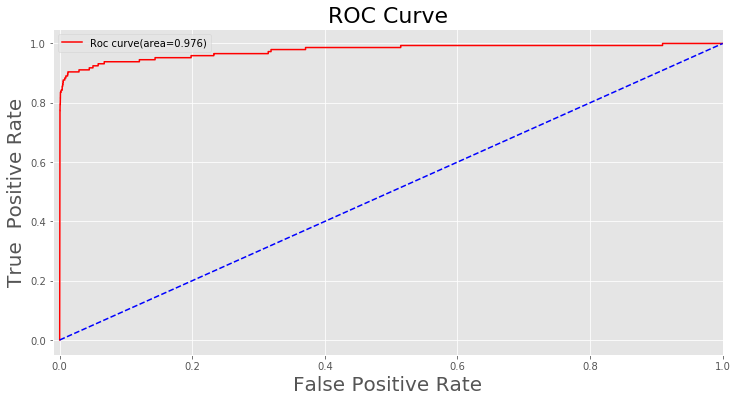

In [45]:
model = LogisticRegression(C=0.06,penalty='l1')
# model = svm.SVC(probability=True)
model.fit(X=x_res, y=y_res)

#对整体数据分割得到的测试集进行测试
all_predprob = model.predict_log_proba(x_test)
all_pred = model.predict(x_test)
# print(metrics.accuracy_score(all_pred,y_test))
my_fpr,my_tpr,threshold = roc_curve(y_test,all_predprob[:,1],pos_label=1)

print(auc(my_fpr,my_tpr))
plt.figure(figsize=(12,6))
plt.style.use('ggplot')
plt.plot(my_fpr,my_tpr,'r-',label ='Roc curve(area=%0.3f)'%auc(my_fpr,my_tpr)) 
plt.legend(loc='best')
plt.xlabel('False Positive Rate',fontsize= 20)
plt.ylabel('True  Positive Rate',fontsize= 20)
plt.title('ROC Curve',fontsize = 22)

plt.plot([0,1],[0,1],'b--')
plt.xlim((-0.01,1))

plt.plot()